<a href="https://colab.research.google.com/github/aachen6/deepTC/blob/master/colab/deepTC_classification_cnn5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DeepTC - CNN5

The objective of *deepTC* can be found on [deepTC github page](https://github.com/aachen6/deepTC/), and the analysis is outlined below.
1. Data Preprocess
 - 1.1 [Satellite images and tracks of TC](https://github.com/aachen6/deepTC/blob/master/colab/deepTC_images_tracks_sync.ipynb)
 - 1.2 [Statistics of satellite images and tracks](https://github.com/aachen6/deepTC/blob/master/colab/deepTC_images_tracks_stats.ipynb)

2. Model for TC Image
 - 2.1 [Post-binding architecture of TC image](https://github.com/aachen6/deepTC/blob/master/colab/deepTC_net_image.ipynb)
 - **2.2 [CNN model for TC image classification ](https://github.com/aachen6/deepTC/blob/master/colab/deepTC_classification_cnn5.ipynb)**
 - 2.3 [Resnet model for TC image classification](https://github.com/aachen6/deepTC/blob/master/colab/deepTC_classification_resnet.ipynb)
 - 2.4 [Resnet model for TC image intensity estimation](https://github.com/aachen6/deepTC/blob/master/colab/deepTC_intensity_resnet.ipynb)
 - 2.5 [Operation of TC image prediction](https://github.com/aachen6/deepTC/blob/master/colab/deepTC_image_prediction.ipynb)

3. Model for TC Track
 - 3.1 [Post-binding architecture of TC track](https://github.com/aachen6/deepTC/blob/master/colab/deepTC_net_track.ipynb)
 - 3.2 [LSTM model for TC track prediction](https://github.com/aachen6/deepTC/blob/master/colab/deepTC_track_lstm.ipynb)
 - 3.3 [LSTM model with attention for TC track prediction](https://github.com/aachen6/deepTC/blob/master/colab/deepTC_track_lstm.ipynb) 
 - 3.4 [LSTM-CNN model for TC track prediction](https://github.com/aachen6/deepTC/blob/master/colab/deepTC_track_lstmcnn.ipynb)

4. Generative Model for TC Image
 - 4.1 [DCGAN model for deepTC](https://github.com/aachen6/deepTC/blob/master/colab/deepTC_generative_dcgan.ipynb)
 - 4.2 [SAGAN model for deepTC](https://github.com/aachen6/deepTC/blob/master/colab/deepTC_generative_sagan.ipynb)

This notebook is where things start to get really fun and excited, as everything will be linked together and put into the action. This notebook focuses on implementation/training of a five-layer convolution network for classification of satellite image of TC based on the system we developed so far. Let's start with importing the necessary python modules. To reuse our previous notebook where the classes for the model, dataset, training, and inference have been defined, we install a package called *import-ipynb*, which loads the .ipynb into current notebook. Since the data is hosted on *Google Drive*, we also mount my *Google Drive* and define some directories here. For new readers, you can find a copy of those datasets in [deepTC github page](https://github.com/aachen6/deepTC/).

In [0]:
!pip install import-ipynb

In [0]:
import os 
import yaml
import numpy as np
import pandas as pd

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

work_dir = r'/content/drive/My Drive/Colab Notebooks/deepTC'
p_data  = work_dir + os.sep + 'data/AL'
p_image = work_dir + os.sep + 'image/AL'
p_class = work_dir + os.sep + 'model/tc_classification'
p_model = p_class  + os.sep + 'cnn5'

# load class defined in other ipynb
import import_ipynb
model_ipynb = work_dir + os.sep + 'deepTC_net_image.ipynb'
with open(model_ipynb, 'rb') as fp:
    with open('deepTC_net_lib.ipynb','wb') as fout:
       fout.write(fp.read())
  
import deepTC_net_lib
from deepTC_net_lib import YML2ModelNet, ImageDataSet, ImageTrainer, ImageInference


##CNN5

In a nutshell, the convolution network is a deep learning algorithm that applies multiple convolution operations (filters) to an input image with each being able to extract certain features (edge, texture, etc.) that are used collectively to differentiate the input image from others and generate specific output, i.e. classification or regression. A good illustration is shown in figure below. The learning algorithm is the process to determine the best convolution operations that minimize the loss defined to measure the difference between the output and the target of images in the training set. To understand how and why this would work, it helps to learn the convolution operation mathematically. The convolution operation performs the integration (summation) of the multiplication of a signal or function (called filter) overlapping with another signal or function (underlying) at a particular alignment of the two; as the filter is moving along the the underlying signal or function, it generates another signal or function. An example would be moving a step filtering function along a underlying function, the underlying function overlapped with the non-zero portion of the step function will be averaged at a particular moment, therefore will be smoothed as the filter moves. By varying the filter function, different information from the underlying function can be obtained through the convolution. 

<img src='https://leonardoaraujosantos.gitbooks.io/artificial-inteligence/content/assets/ezgif.com-optimize.gif'>*Image credit: Leonardoaraujosantos

For the convolution network, the filter generates feature maps, and the feature size is similar to the resolution, i.e. dimension of pixels. The number of filters at each layer is called filter depth or channels (similar to an image with RGB channels).  The filter size or kernal size defines the portion of image (reception field) that is processed at a time during the convolution (similar to step function size in the example above), which may move at different stride, i.e. pixels the filter slides. Zero padding can be used to maintain the feature size. The algorithom will learn a series of filters that extract different information from the original images, which are used collectively to make prediction, i.e. classfication or regression associated with the images.


###Network Architecture
The overall network architecture and training parameters are defined in the configuration file. Specifically, it simply defines a sequential five-layer (number of convolution layers rather than conventionally total number of layers) convolution network (*CNN5 net*) as shown in figure below. The input images are greyscale with only one channel. The first layer increases the channel size to 32 with 32 5 x 5 filters and reduces the feature size by a factor of four using *maxpool2d* function with stride of 2. In each of the following layer, the channel size is doubled with 3 x 3 filters while the feature size is quartered using *maxpool2d* with stride of 2 in each layer as shown in the callout box. *ReLU* activation function is used for each layer. The features are then flattened and transformed with two fully connected layers into a vector of 7 corresponding to the number of classes. 
 
<img src='https://raw.githubusercontent.com/aachen6/deepTC/master/model/tc_classification/cnn5/cnn5.png' width='800'/>

The dataset is split randomly into 90% of training and 10% testing as specified in the configuration file, where the 90% training data is further split randomly into 80% of training and 20% of validation with a final separation ratio of 72:18:10 as shown in the training log below. The ratio of number of samples for each class is preserved during the split. Since this is a multi-class classification problem, we used *Cross-Entropy* loss with *Adam* optimizer. The default learning rate &eta;=0.001 and momentum parameters (&beta;<sub>1</sub>=0.9, &beta;<sub>2</sub>=0.999) are used. 

We trained the model for 15 epochs with a batch size of 64. The loss and accuracy of each batch and epoch (running average) are generated and updated in the plot below during the training and validation process. The model converges very rapidly reaching a validation accuracy of over 95% only after 4 epochs. Since validation is performed after training, it presents lower loss and higher accuracy than that from training at the beginning. While the loss decreases and the accuracy increases, they become larger and less than that from training, respectively, indicating the training starts to get saturated. The model achieved a final validation accuary of 96.7% after 15 epochs.

###Training and Validation

In [0]:
import torch
from torchvision.transforms import transforms

torch.cuda.empty_cache()

# load configuration file
f_config = p_model + os.sep + 'config_cnn5.yaml'
with open(f_config, 'r') as fp: config = yaml.load(fp)

# contruct the model
storm_cnn = YML2ModelNet(config, 'cnn5')

# update path for config
config_params = config['params']
config_params['f_image_zip'] = p_image + os.sep + config_params['f_image_zip']
config_params['f_storm_msg'] = p_data  + os.sep + config_params['f_storm_msg']
config_params['f_data_yml']  = p_class + os.sep + config_params['f_data_yml']
config_params['f_state_yml'] = p_model + os.sep + config_params['f_state_yml']
config_params['f_model_pth'] = p_model + os.sep + config_params['f_model_pth']
config_params['f_test_yml']  = p_model + os.sep + config_params['f_test_yml']

# normalization is based on ramdon 1000 samples for this test
image_transforms = transforms.Compose([
    transforms.Grayscale(1),
    transforms.ToTensor(),
    transforms.Normalize((0.456,), (0.222,))])

# dataset
storm_data = ImageDataSet(config_params, image_transforms, hotstart=False)
data_split = storm_data.load_data()

# model
storm_train = ImageTrainer(config_params, storm_cnn, hotstart=False)

# train & valid
storm_train.train_loop(data_split)

# test
test_results = storm_train.test_loop(data_split)


------------------------------------
summary of dataset
------------------------------------
               train     valid      test
percent         0.72      0.18      0.10
size           34944      8742      4857
batch            546       136        75
------------------------------------
summary of GPU
------------------------------------
Tesla K80
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
------------------------------------
training
------------------------------------


------------------------------------
summary of epoch: 0
------------------------------------
loss -           train     valid
                 1.101     0.772
accuracy/error - 
                58.757    71.912
 


------------------------------------
summary of epoch: 1
------------------------------------
loss -           train     valid
                 0.483     0.279
accuracy/error - 
                83.233    91.309
 


------------------------------------
summary of epoch: 2
------------------------------------
loss -           train     valid
                 0.207     0.172
accuracy/error - 
                93.312    94.886
 


------------------------------------
summary of epoch: 3
------------------------------------
loss -           train     valid
                 0.121     0.154
accuracy/error - 
                96.057    95.571
 


------------------------------------
summary of epoch: 4
------------------------------------
loss -           train     valid
                 0.078     0.179
accuracy/error - 
                97.548    94.955
 


------------------------------------
summary of epoch: 5
------------------------------------
loss -           train     valid
                 0.068     0.161
accuracy/error - 
                97.668    96.171
 


------------------------------------
summary of epoch: 6
------------------------------------
loss -           train     valid
                 0.061     0.160
accuracy/error - 
                98.011    96.198
 


------------------------------------
summary of epoch: 7
------------------------------------
loss -           train     valid
                 0.051     0.134
accuracy/error - 
                98.375    96.909
 


------------------------------------
summary of epoch: 8
------------------------------------
loss -           train     valid
                 0.055     0.136
accuracy/error - 
                98.126    96.685
 


------------------------------------
summary of epoch: 9
------------------------------------
loss -           train     valid
                 0.032     0.182
accuracy/error - 
                98.918    96.430
 


------------------------------------
summary of epoch: 10
------------------------------------
loss -           train     valid
                 0.048     0.131
accuracy/error - 
                98.452    96.928
 


------------------------------------
summary of epoch: 11
------------------------------------
loss -           train     valid
                 0.034     0.369
accuracy/error - 
                98.884    91.327
 


------------------------------------
summary of epoch: 12
------------------------------------
loss -           train     valid
                 0.040     0.113
accuracy/error - 
                98.752    97.685
 


------------------------------------
summary of epoch: 13
------------------------------------
loss -           train     valid
                 0.033     0.175
accuracy/error - 
                98.935    96.244
 


------------------------------------
summary of epoch: 14
------------------------------------
loss -           train     valid
                 0.033     0.173
accuracy/error - 
                98.918    96.696
 
------------------------------------
summary of test
------------------------------------
               total  accuracy
test            4857    96.356


###Test Performance

Let's now take a look at the model performance on the test dataset. The overall test accuracy is 96.3%. However, the analysis in [Statistics of satellite images and tracks](https://) shows that the number of sample for each class is not well balanced, prediction heavily biased towards the class with majority of the samples will not hurt the overal accuracy. To verify that, the confusion matrix is generated. Surprisingly, the confusion matrix shows that the model perform well with similar accuracy for classes with less samples, indicating the model is not sensitive to such imbalance in the sample classes. To ensure the best practices, we can penalize the loss based on the sample size ratio of each class, but is not demonstrated here. Next, we will turn our attention to residual network to see if we can further improve the accuracy of the prediction.

------------------------------------
summary of test
------------------------------------
               total  accuracy
test            4857    96.356


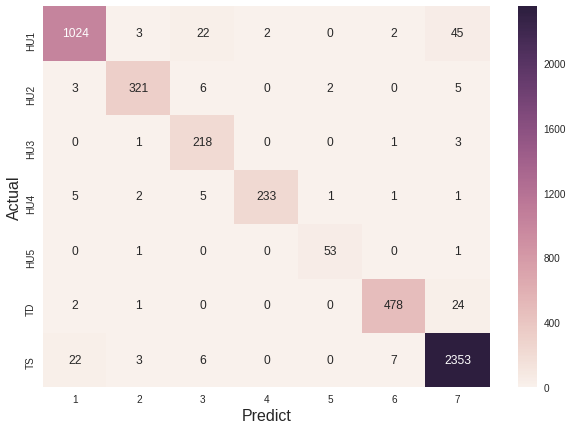

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# CONSTANT
f_data_yml = config_params['f_data_yml']
with open(f_data_yml, 'rb') as fp: data = yaml.load(fp)
    
one_hot_key   = data['one_hot_key']
one_hot_rev   = data['one_hot_rev']
train_indices = data['indices']['train']
valid_indices = data['indices']['valid']
test_indices  = data['indices']['test']

f_test = config_params['f_test_yml']
with open(f_test, 'r') as fp: test_results = yaml.load(fp)
test_idxs = test_results['idxs']
#test_idxs = test_idxs.detach().numpy()
test_labels = test_results['labels']
test_predicts = test_results['predicts']
   
# check test data, for debug purpose to make sure test dataset is correct
# f_img_msg = p_data + os.sep + 'al_ir_track_filtered.msg'
# pd_storm = pd.read_msgpack(f_img_msg) 
# print(len(test_labels))
# print(len(pd_storm.iloc[test_indices].index))
# print(pd_storm.iloc[test_indices].groupby(b'cat').count())
# print(np.unique(test_labels, return_counts=True))

# test summary
n_correct = np.equal(test_predicts, test_labels).sum().item()
accuracy = n_correct / len(test_labels) * 100.
divider = '-' * 36
print(divider)
print('summary of test')
print(divider)
print('{:<10s}{:>10s}{:>10s}'.format('', 'total', 'accuracy'))
print('{:<10s}{:>10d}{:>10.3f}'.format('test', len(test_labels), accuracy))   

# confusion matrix
cfx = confusion_matrix(test_labels, test_predicts)
df_cfx = pd.DataFrame(cfx, index = [one_hot_rev[i] for i in range(7)], 
                           columns = [str(i+1) for i in range(7)])

fig, ax = plt.subplots(figsize = (10,7))
sns.heatmap(df_cfx, annot=True, annot_kws={'size': 12}, fmt='d', ax=ax)
ax.set_xlabel('Predict',fontsize=16)
ax.set_ylabel('Actual',fontsize=16)

# true_to_false
true_to_false = {} # miss-classified images
for i in range(7): true_to_false[one_hot_rev[i]] = []
for i, (x, y) in enumerate(zip(test_labels, test_predicts)):
    if x==y: continue
    true_cat = one_hot_rev[x]
    false_cat = one_hot_rev[y]
    true_to_false[true_cat].append([test_idxs[i], false_cat])
    